In [38]:
import tensorflow as tf
import PIL
import random
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow import keras
import json
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt

In [4]:
def makeDataSet(directory, tokenizer, train_ratio):
    files = os.listdir(directory)
    random.shuffle(files)
    x_train=[]
    y_train=[]
    x_validation=[]
    y_validation=[]
    for f in files[:int(train_ratio*len(files))]:
        pil=tf.keras.utils.load_img(os.path.join(directory,f),color_mode='grayscale')
        npArray = tf.keras.utils.img_to_array(pil)/255.
        x_train.append(npArray)
        y_train.append(f[:-4])
    for f in files[int(train_ratio*len(files)):]:
        pil=tf.keras.utils.load_img(os.path.join(directory,f),color_mode='grayscale')
        npArray = tf.keras.utils.img_to_array(pil)/255.
        x_validation.append(npArray)
        y_validation.append(f[:-4])
    return np.array(x_train), np.array(y_train), np.array(x_validation), np.array(y_validation)

In [5]:

directory = "CAPTCHA"
files = os.listdir(directory)
random.shuffle(files)

labels = []

for i in files:
    labels.append(i[:-4])

    
tokenizer=tf.keras.preprocessing.text.Tokenizer(char_level=True, oov_token = "NA")

tokenizer.fit_on_texts(labels)

In [6]:
split_ratio = .9 
batch_size = 32
#xt,yt,xv,yv = makeDataSet(directory,tokenizer,.9)
xt = []
yt = []
xv = []
yv = []
for i in files[:int(len(files)*split_ratio)]:
    xt.append(os.path.join(directory,i))
    yt.append(tokenizer.texts_to_sequences(i[:-4]))
for i in files[int(len(files)*split_ratio):]:
    xv.append(os.path.join(directory,i))
    yv.append(tokenizer.texts_to_sequences(i[:-4]))

def encode_sample(img_path, label): 
    img = tf.io.read_file(img_path) 
    img = tf.io.decode_png(img, channels=1) 
    img = tf.image.convert_image_dtype(img, tf.float32) 
    img = tf.transpose(img, perm=[1, 0, 2])
    img = tf.image.resize(img, [150, 40]) 
    return {"image": img, "label": label} 

dataset_train = tf.data.Dataset.from_tensor_slices((xt, yt)) 
dataset_train = (dataset_train.map(encode_sample, num_parallel_calls=tf.data.AUTOTUNE) .batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE) ) 

dataset_validation = tf.data.Dataset.from_tensor_slices((xv, yv))
dataset_validation = (dataset_validation.map(encode_sample, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name = None):
        super().__init__(name = name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype = "int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
        input_length = input_length * tf.ones(shape = (batch_len,1), dtype = "int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype = "int64")
        label_length = label_length * tf.ones(shape = (batch_len,1), dtype = "int64")
        loss = self.loss_fn(y_true, y_pred, 
                            input_length, label_length)
        self.add_loss(loss)
        return y_pred
###

In [39]:

input_img = tf.keras.layers.Input(shape = (150, 40, 1), 
                               name = "image", dtype = "float32")
labels = tf.keras.layers.Input(name = "label", 
               shape = (None,), dtype = "float32")
x=tf.keras.layers.Conv2D(32, (3,3), activation ='relu')(input_img)
x=tf.keras.layers.MaxPooling2D(2,2)(x)
x=tf.keras.layers.Conv2D(64, (3,3), activation = 'relu')(x)
x=tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Reshape(target_shape = ((36), 8*64))(x)
x=tf.keras.layers.Dense(512, activation ='relu')(x)
x=tf.keras.layers.Dropout(.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True))(x)
x=tf.keras.layers.Dense(512, activation ='relu')(x)
x=tf.keras.layers.Dense(len(tokenizer.get_config()['word_index'])+1, activation ='softmax', name = 'output')(x)
output=CTCLayer(name = "ctc_loss")(labels,x)
model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output
    )
model.compile(optimizer = 'adam')
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience =10)

In [8]:
history = model.fit(
            dataset_train,
            validation_data=dataset_validation,
            epochs=100,
            callbacks=[callback]
            )

Epoch 1/100
563/563 [==============================] - 121s 199ms/step - loss: 21.2726 - val_loss: 19.3146
Epoch 2/100
563/563 [==============================] - 121s 214ms/step - loss: 18.9335 - val_loss: 18.5662
Epoch 3/100
563/563 [==============================] - 131s 232ms/step - loss: 18.5152 - val_loss: 18.4275
Epoch 4/100
563/563 [==============================] - 130s 230ms/step - loss: 18.4275 - val_loss: 18.3890
Epoch 5/100
563/563 [==============================] - 121s 214ms/step - loss: 18.4345 - val_loss: 18.2685
Epoch 6/100
563/563 [==============================] - 120s 213ms/step - loss: 18.1607 - val_loss: 17.9516
Epoch 7/100
563/563 [==============================] - 127s 225ms/step - loss: 17.5946 - val_loss: 17.1120
Epoch 8/100
563/563 [==============================] - 125s 221ms/step - loss: 16.8394 - val_loss: 16.4515
Epoch 9/100
563/563 [==============================] - 122s 216ms/step - loss: 15.7135 - val_loss: 14.7726
Epoch 10/100
563/563 [===============

In [16]:

def decodeResult(code):
    results = []
    for label in code:
        results.append(tokenizer.sequences_to_texts(np.argmax(code,0))) 
    return results

In [25]:
predModel = tf.keras.models.Model(model.input[0], model.get_layer(name='output').output)


1/1 [==============================] - 0s 61ms/step
tf.Tensor(
[19 23 10 26  8 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1], shape=(36,), dtype=int64)


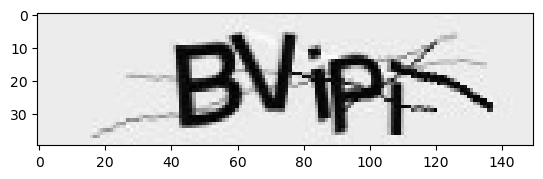

b v i p j


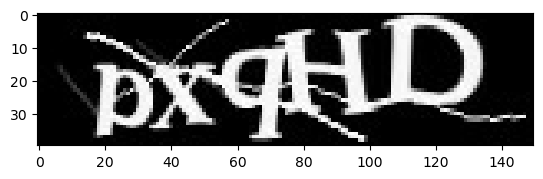

p x q h d


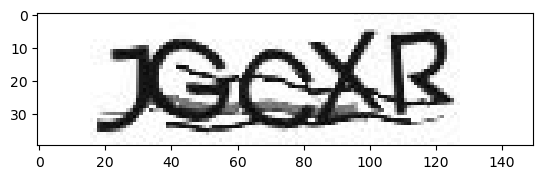

j g c x r


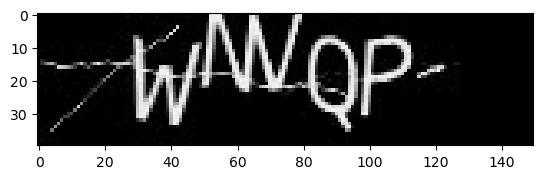

w w q p NA


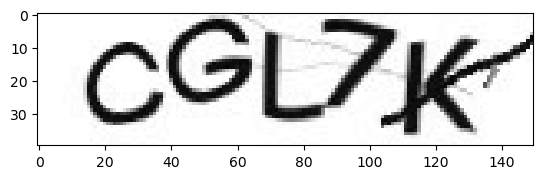

c g l 7 k


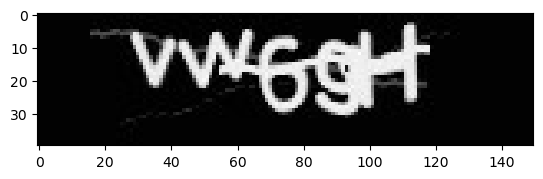

v w 6 g h


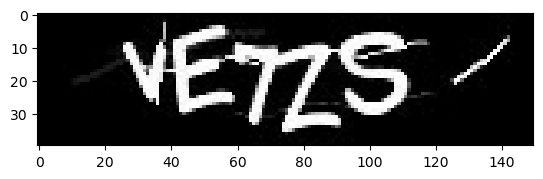

v e 7 z s


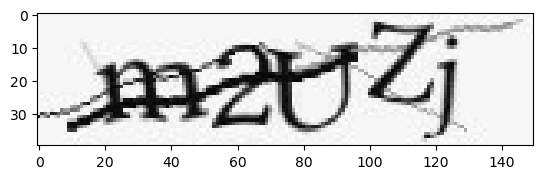

m 2 u z j


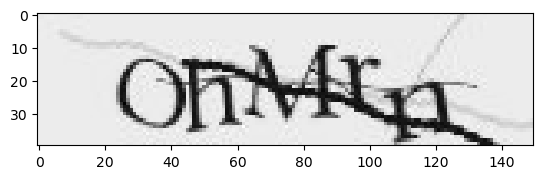

o h m t u


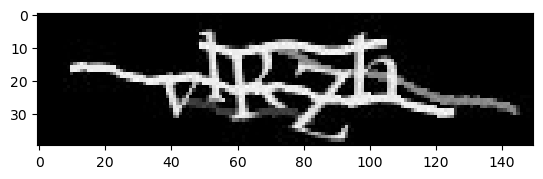

v l l r z


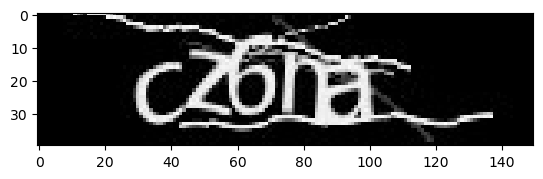

c z 6 m n


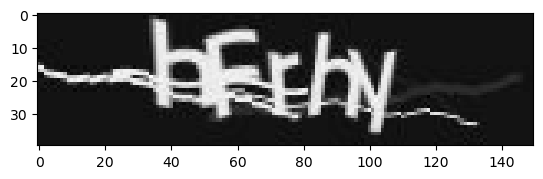

h f r h y


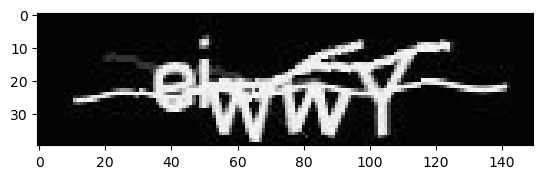

e i w w y


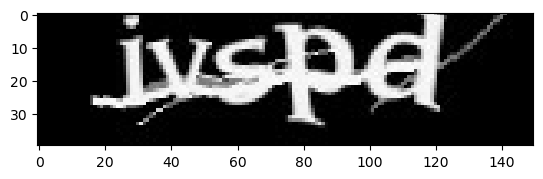

i v s p d


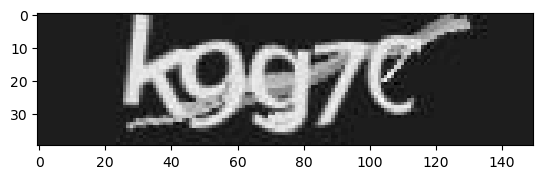

k o g 7 c


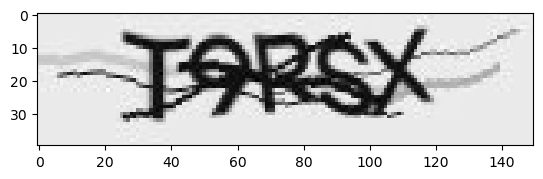

t 9 r s x


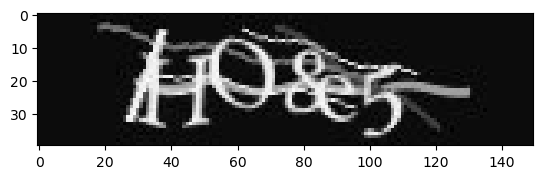

h h o 8 e


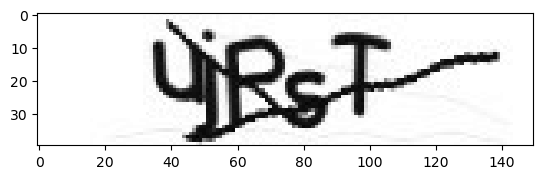

u j r s t


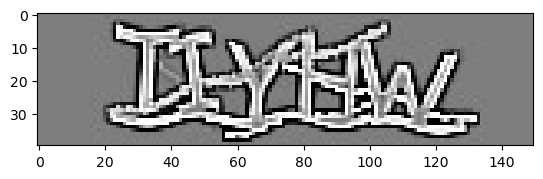

t i y h w


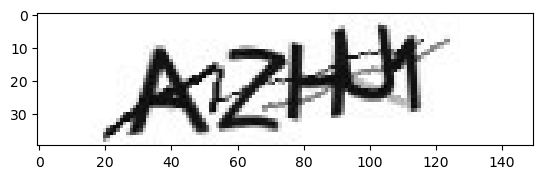

a z h u 1


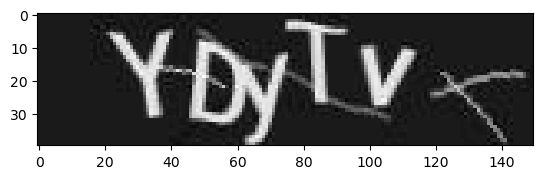

y d y t v


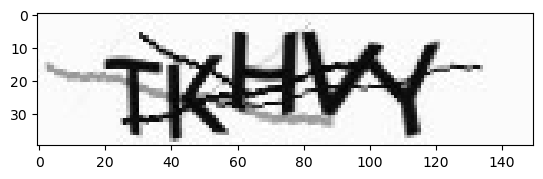

t k h v y


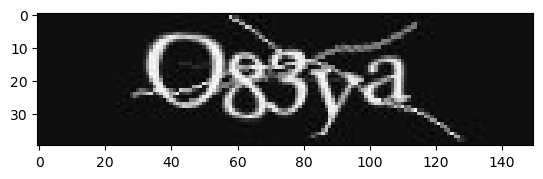

o 8 3 y a


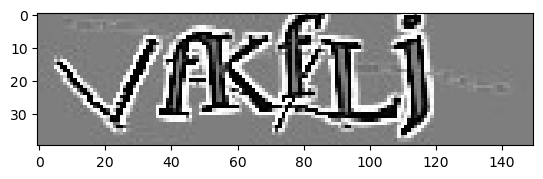

7 f k f u


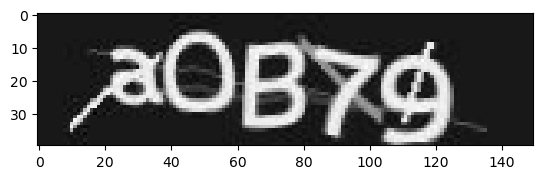

a o b 7 9


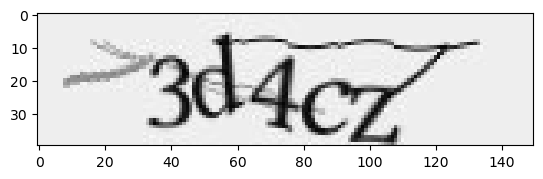

3 d 4 c z


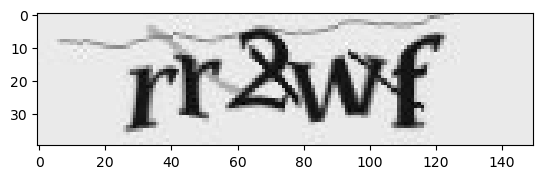

r r 2 w f


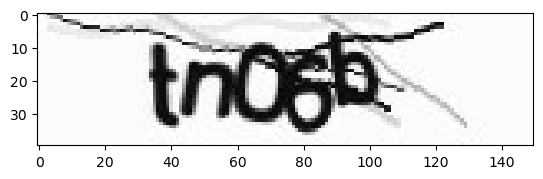

t n o 6 b


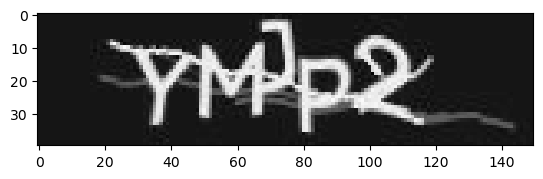

y m j p 9


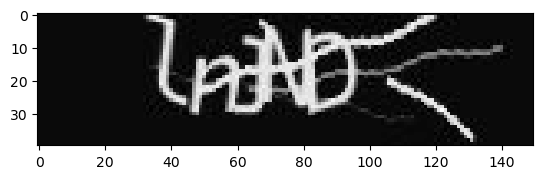

t n j n d


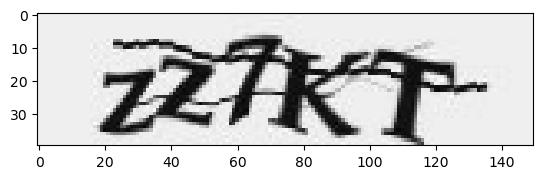

z z 7 k t


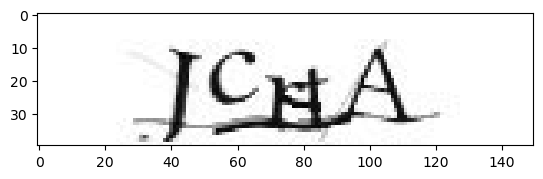

j c u i a


In [37]:
def ctc_decode(y_pred):
    input_shape = tf.shape(y_pred)
    input_len = np.ones(y_pred.shape[0]) * y_pred.shape[1]
    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())
    (decoded, log_prob) = tf.nn.ctc_greedy_decoder(inputs=y_pred, sequence_length=tf.cast(input_len, tf.int32))
    st = tf.SparseTensor(decoded[0].indices, decoded[0].values, (input_shape[0], input_shape[1]))
    st = tf.sparse.to_dense(sp_input=st, default_value=-1)
    print(st[0])
    return st


def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = ctc_decode(pred)[:,:5]
    output_text = []
    for ans in results:
        listfyied = [tf.make_ndarray(tf.make_tensor_proto(ans)).tolist()]
        ans_char = tf.strings.reduce_join(tokenizer.sequences_to_texts(listfyied)).numpy().decode("utf-8")
        output_text.append(ans_char)
    return output_text



for batch in dataset_validation.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    image_num = 0
    for label in pred_texts:
        #PIL.Image.fromarray(batch_images[0])
        plt.imshow(tf.keras.utils.array_to_img(tf.transpose(batch_images[image_num],perm=[1, 0, 2])),cmap='gray')
        plt.show()
        print(label)
        image_num +=1
        
        